In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics._scorer import make_scorer
import numpy as np
from loguru import logger
import matplotlib.pyplot as plt

import missingno as msno
# from scipy.stats import randint

# from utils import SpaceTimeSplits
# from metrics import get_metrics

# pd.options.mode.chained_assignment = None   # to disable chained assignment warning (by default, this is "warn")

In [2]:
# train_data = pd.read_csv("../data/train_clean_v1.csv")
train_data = pd.read_csv("D:/Research/AIST/data/train_raw.csv")
val_data = pd.read_csv("D:/Research/AIST/data/validation_v1.csv")

C:\Users\Zhang\AppData\Local\Temp\ipykernel_38064\226401938.py:2: DtypeWarning: Columns (176,180,182) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("D:/Research/AIST/data/train_raw.csv")


In [3]:
labels = ["value"]
to_discard_cols = [
    "Unnamed: 0",   # just the row number
    "space_group",
    "lat_group",
    "long_group",
    "time_group",
    ".partitions",
    "TZID", #timezone id (all are UTC)
    "dswe",     # all are 1
    "source",   #all are "WQP"
    "characteristicName",   # all are TSS
    "parameter",   # all are TSS
    "harmonized_unit",  # same values for all rows (mg/l)
    "date_only",    # all are False
]

In [4]:
train_data.nunique().sort_values()

TOT_EVI_AMJ_2012        0
HWNodeSqKM              0
ACC_ECOL3_34            1
harmonized_unit         1
source                  1
                    ...  
B.RN                27332
swir1_sd            27994
uniqueID            28933
rn                  28933
Unnamed: 0          28933
Length: 478, dtype: int64

In [5]:
train_data.describe()

Unnamed: 0       azimuth     dswe       dswe_sd     elevation  \
count  28933.000000  28933.000000  28933.0  28933.000000  24818.000000   
mean   14466.000000    135.837955      1.0      0.134658    174.144492   
std     8352.382006     16.023701      0.0      0.160863    340.678657   
min        0.000000     86.982834      1.0      0.000000    -69.000000   
25%     7233.000000    125.690483      1.0      0.000000      0.000000   
50%    14466.000000    138.233353      1.0      0.000000     13.000000   
75%    21699.000000    148.300949      1.0      0.253395    219.000000   
max    28932.000000    166.669846      1.0      0.500000   3092.000000   

          hillshade  hillshadow  hillshadow_sd          path    pixelCount  \
count  24237.000000     24560.0   24481.000000  28933.000000  28933.000000   
mean     157.522218         1.0       0.002545     19.622092     76.366675   
std       38.914794         0.0       0.027037      7.026450     49.721178   
min       29.000000         1.0       0.000000     12.000000      3.000000   
25%      123.000000         1.0       0.000000     15.000000     28.000000   
50%      152.000000         1.0       0.000000     16.000000     73.000000   
75%      192.000000         1.0       0.000000     23.000000    136.000000   
max      255.000000         1.0       0.500000     47.000000    143.000000   

       ...  ACC_TAV7100_ANN  TOT_TAV7100_ANN  CAT_WB5100_ANN  ACC_WB5100_ANN  \
count  ...     18416.000000     18416.000000    18416.000000    18416.000000   
mean   ...        12.385450         8.907794      282.849045      304.233127   
std    ...         5.518261         6.992500      157.844760      160.352974   
min    ...        -0.720000        -0.720000        1.000000        2.870000   
25%    ...         7.600000         0.000000      166.957500      179.430000   
50%    ...        12.750000         9.220000      306.210000      333.810000   
75%    ...        15.150000        13.510000      374.000000      388.750000   
max    ...        23.370000        23.210000     1631.450000     1528.400000   

       TOT_WB5100_ANN       uniqueID             n        julian  \
count     18416.00000   28933.000000  28933.000000  28933.000000   
mean        305.11984   61127.287077  26294.714098  13184.805101   
std         160.18750   37529.117996  14951.860524   2512.215536   
min           2.87000       1.000000     11.000000   5215.000000   
25%         181.88500   29336.000000  10591.000000  11640.000000   
50%         340.74000   58422.000000  29407.000000  13347.000000   
75%         389.24000   91374.000000  32784.000000  14903.000000   
max        1528.40000  152264.000000  44680.000000  17696.000000   

                mag  .partitions  
count  28919.000000      28933.0  
mean       0.657674          1.0  
std        0.299467          0.0  
min        0.200000          1.0  
25%        0.400000          1.0  
50%        0.750000          1.0  
75%        0.930000          1.0  
max        1.000000          1.0  

[8 rows x 444 columns]

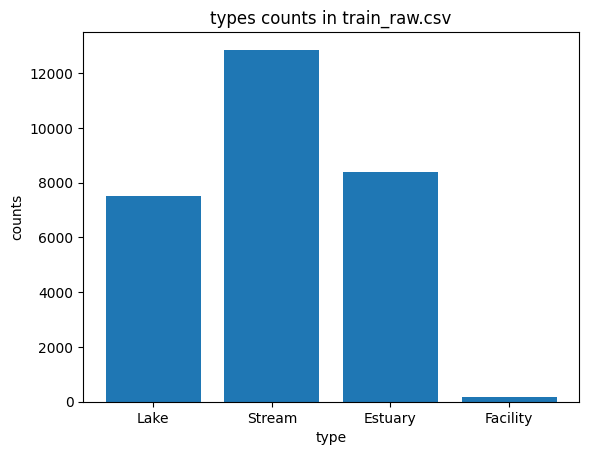

In [6]:
types =  [len(train_data.loc[train_data['type'] == "Lake"])]
types.append(len(train_data.loc[train_data['type'] == "Stream"]))
types.append(len(train_data.loc[train_data['type'] == "Estuary"]))
types.append(len(train_data.loc[train_data['type'] == "Facility"]))
plt.xlabel("type")
plt.ylabel("counts")
plt.bar(["Lake", "Stream", "Estuary", "Facility"], types)
plt.title("types counts in train_raw.csv")
plt.show()


# Remove irrelevant features

In [53]:
ctr = 0
tot_ctr = 0
incomplete_cols = []
for col in train_data.columns:
    if col in labels or col in to_discard_cols:
        continue
    tot_ctr += 1
    num_missing = np.sum(train_data[col].isnull())
    if num_missing>0:
        ctr += 1
        # print(col, num_missing)
        incomplete_cols.append(col)
print(f"Found {ctr} out of {tot_ctr} features with missing values")

# Remove cols with missing values
for col in incomplete_cols:
    if col in train_data.columns:
        train_data = train_data.drop(col, axis=1)
# Remove uninformative columns
for col in to_discard_cols:
    if col in train_data.columns:
        train_data = train_data.drop(col, axis=1)

Found 0 out of 95 features with missing values


<AxesSubplot: >

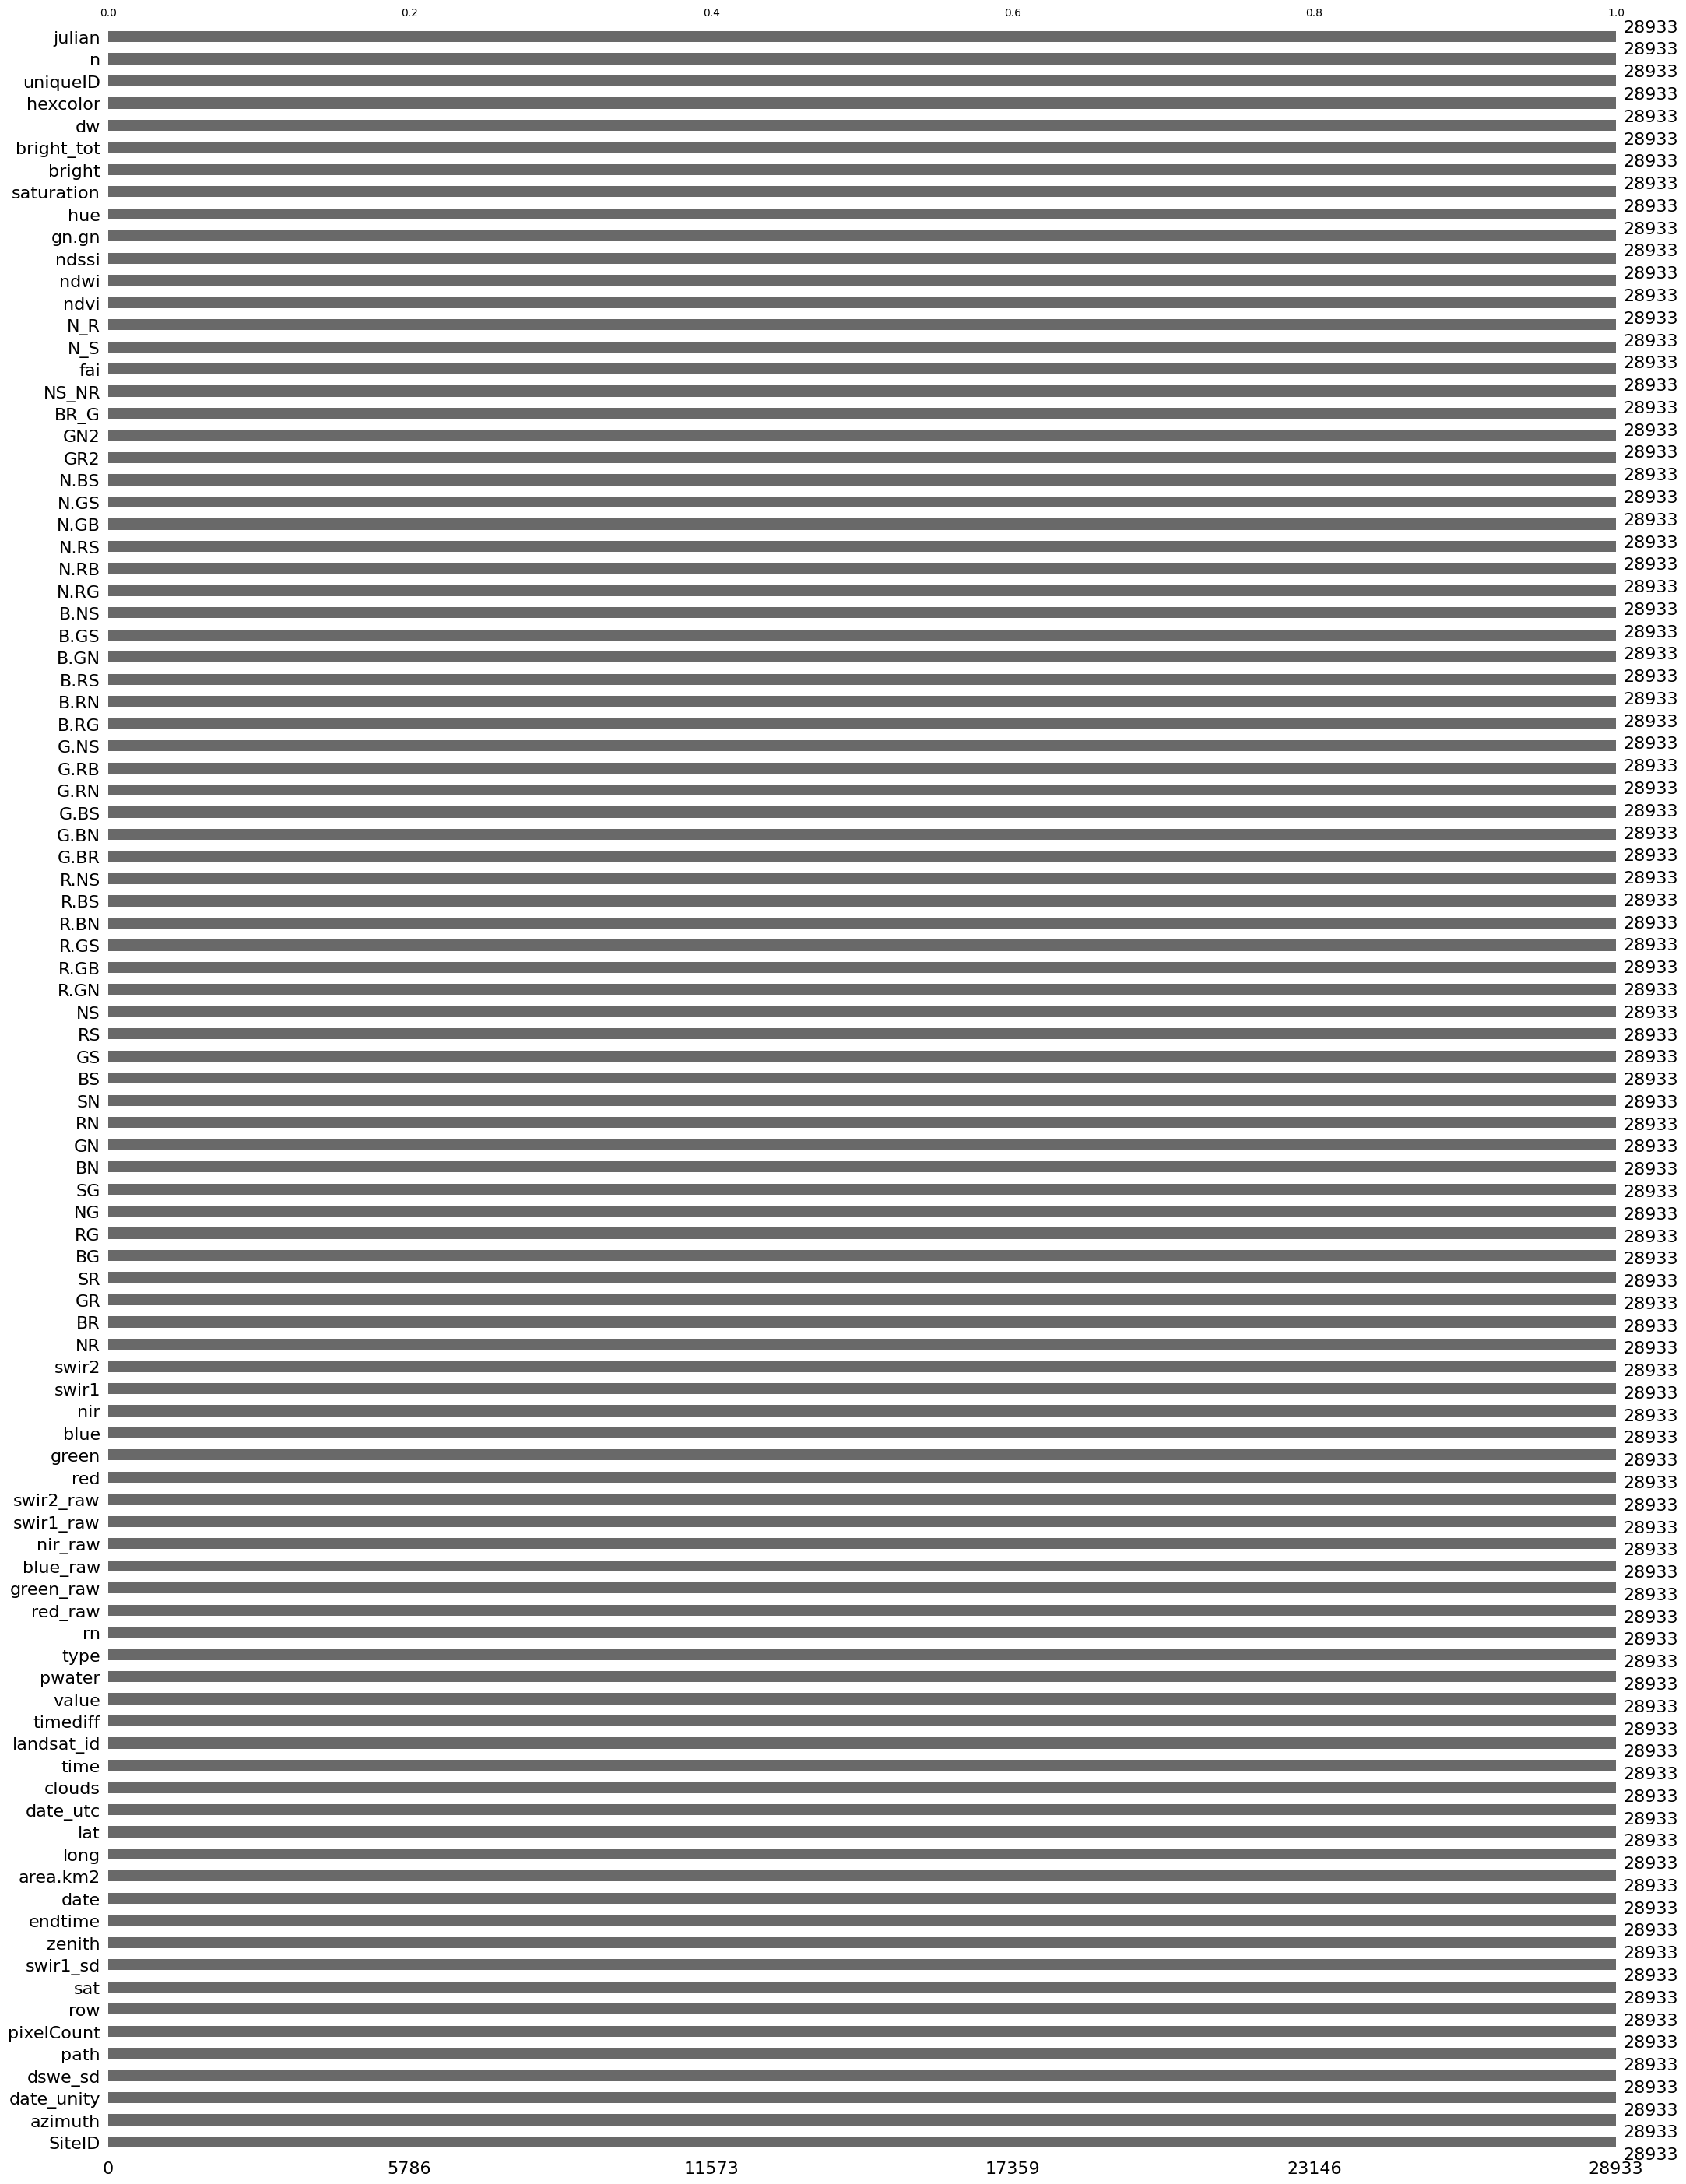

In [59]:
msno.bar(train_data)

In [35]:
train_data["type"].value_counts()

Stream      12850
Estuary      8378
Lake         7524
Facility      181
Name: type, dtype: int64

In [60]:
train_data.shape

(28933, 96)

Left with 96 columns/features after cleaning (includes the label)

# Plot correlation between features

In [63]:
import pandas as pd
import numpy as np

rs = np.random.RandomState(0)
# df = pd.DataFrame(rs.rand(10, 10))
corr = train_data.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/1l/36wkr52s0qg1mbnfl6h1v30m0000gn/T/ipykernel_51882/4221770215.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_data.corr()
